In [1]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

2022-11-01 02:25:11.169109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 02:25:11.169189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
train_data_set = pd.read_csv("/home/mdirfan-code/projects/Sentimeter-v1.0/BERT_Model/Datasets/Training_dataset.csv")
train_data_set

,Unnamed: 0,sentiment,tweet_text
0,49647,Irrelevant,Last Weekend league for Fifa 20 Glad I could f...
1,43676,Positive,omg i'm so excited to watch dk play pubg
2,55915,Negative,all others who have problems with
3,14927,Positive,in
4,44039,Irrelevant,minho felix de jeongin sucked at pubg pretty h...
...,...,...,...
59191,37541,Negative,you
59192,6332,Neutral,I'm not even going to show a 7 2 loss.
59193,55392,Negative,Fuck this call of duty update..
59194,864,Positive,I should get up feed my dogs such that way whe...


In [4]:
test_data_set = pd.read_csv("/home/mdirfan-code/projects/Sentimeter-v1.0/BERT_Model/Datasets/Testing_dataset.csv")
test_data_set

,Unnamed: 0,sentiment,tweet_text
0,61413,Irrelevant,Looks to me like he failed to check out the wa...
1,44887,Irrelevant,Wow it takes all sorts of crazy people out the...
2,73662,Neutral,Nvidia Unveils The World s Fastest Gaming Moni...
3,36694,Neutral,Huge radio play here. Reinvention Corporate Ev...
4,2308,Negative,SO I HAPPY WHO ABOUT THIS.
...,...,...,...
14795,12630,Negative,where is all my Mamba Edition extras? I m bee...
14796,49615,Negative,Sell 700k fifa coins fucking this game
14797,12322,Negative,107 for a four game break and I can't even ev...
14798,4355,Irrelevant,has called me a madman.. I understood right fr...


In [5]:
test_data_set.drop('Unnamed: 0',axis=1,inplace=True)
test_data_set

,sentiment,tweet_text
0,Irrelevant,Looks to me like he failed to check out the wa...
1,Irrelevant,Wow it takes all sorts of crazy people out the...
2,Neutral,Nvidia Unveils The World s Fastest Gaming Moni...
3,Neutral,Huge radio play here. Reinvention Corporate Ev...
4,Negative,SO I HAPPY WHO ABOUT THIS.
...,...,...
14795,Negative,where is all my Mamba Edition extras? I m bee...
14796,Negative,Sell 700k fifa coins fucking this game
14797,Negative,107 for a four game break and I can't even ev...
14798,Irrelevant,has called me a madman.. I understood right fr...


In [6]:
train_data_set.drop(['Unnamed: 0'],axis=1,inplace=True)
train_data_set


,sentiment,tweet_text
0,Irrelevant,Last Weekend league for Fifa 20 Glad I could f...
1,Positive,omg i'm so excited to watch dk play pubg
2,Negative,all others who have problems with
3,Positive,in
4,Irrelevant,minho felix de jeongin sucked at pubg pretty h...
...,...,...
59191,Negative,you
59192,Neutral,I'm not even going to show a 7 2 loss.
59193,Negative,Fuck this call of duty update..
59194,Positive,I should get up feed my dogs such that way whe...


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_set['tweet_text'].values,train_data_set['sentiment'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_set['tweet_text'].values,test_data_set['sentiment'].values))

2022-11-01 02:25:17.878159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 02:25:17.878217: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 02:25:17.878235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Mi-Notebook-Ultra): /proc/driver/nvidia/version does not exist
2022-11-01 02:25:17.878638: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
train_data_set['sentiment'].value_counts()

Negative      17978
Positive      16536
Neutral       14503
Irrelevant    10179
Name: sentiment, dtype: int64

In [9]:
table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant([ 'Negative','Positive', 'Neutral', 'Irrelevant']),
        values=tf.constant([0,1,2,3])
    ),
    default_value=tf.constant(-1),
    name = "target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)
    

In [10]:
def show_batch(dataset, size=5):
    for batch, label in dataset.take(size):
        print(batch.numpy())
        print(target(label).numpy())

In [11]:
show_batch(train_dataset,6)

b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9'
3
b"omg i'm so excited to watch dk play pubg"
1
b'all others who have problems with'
0
b'in'
1
b"minho felix de jeongin sucked at pubg pretty hard today I'm just.. I'm less different than them at 1 thing"
3
b"I appreciate any advice suggestions on this pleeeeease if it's doing hot noodle canister in! All game action was smooth before. This choppy capture is not good. It was fine capturing in OBS before the Nvidia driver update for my RTX GPUs already NERDIOD help NEEDED! "
0


In [12]:
def fetch(text, labels):
    return text, tf.one_hot(target(labels),4)

In [13]:
train_data_f = train_dataset.map(fetch)
test_data_f = test_dataset.map(fetch)

In [14]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9'>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>)

In [15]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Last Weekend league for Fifa 20 Glad I could finish strong . . Birthday Mbappe and TOTS de Bruyne were absolutely clutch . pic.twitter.com n1766sVgP9',
        b"omg i'm so excited to watch dk play pubg",
        b'all others who have problems with', b'in',
        b"minho felix de jeongin sucked at pubg pretty hard today I'm just.. I'm less different than them at 1 thing"],
       dtype=object)>,
 <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
 array([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32)>)

In [16]:
# embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[],
#                             dtype = tf.string, trainable= True
#     )
# hub_layer(train_data[:1])

In [17]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight('balanced', classes = np.unique(train_data_set['sentiment']) ,y=train_data_set['sentiment']))

In [18]:
class_weights
# np.unique(train_data_set['sentiment'])

[1.4538756262894195,
 0.8231727667148737,
 1.0204095704337033,
 0.8949564586357039]

In [19]:
class_weights.sort()
np.unique(train_data_set['sentiment'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [20]:
weights = {}
for index, weight in enumerate(class_weights):
    weights[index] = weight
weights


{0: 0.8231727667148737,
 1: 0.8949564586357039,
 2: 1.0204095704337033,
 3: 1.4538756262894195}

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_data_f = train_data_f.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data_f = test_data_f.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
for example, label in train_data_f.take(1):
    print('texts: ', example.numpy())
    print()
    print('labels: ', label.numpy())

texts:  [b'HAHAHAHAHAHA these og gy secret twitter person r fuckin funny'
 b'Depot hot dogs are the second best after Red Run Golf Club which comes in at number one... IYKYK'
 b'I played this interesting quiz on Amazon Try your luck for a chance to win exciting rewards amazon.in game share g0R...'
 b' dbongino And really fast because I have to walk to Home Depot and of course touch everything with my rubber gloves. But 7 days ago they predicted up to 2 million deaths for Covit19 in the US. 3 days later they predicted 100 to 200 000. And a mortality rate of less than 2 .'
 b"If they have to buy studios to get games that's basically a sign of a failed console."
 b'Everyone is upset because it looks like an Xbox but no one mentions the function. Good contrast! It looks very comfortable in size and shape.'
 b"You seriously fools people think banning a game will increase our growing GDP and effect anything there'ain s this is joke of like the day.. the person who has should be ban is our fi

In [23]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_data_f.map(lambda text, label:text))

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:12]

array(['', '[UNK]', 'the', 'i', 'to', 'and', 'a', 'of', 'is', 'for', 'in',
       'this'], dtype='<U27')

In [25]:
example = ["this is my game", "I love Myself more than anything","why me nivea"]
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   8,  15,  18,   0,   0],
       [  3,  58, 491,  63, 132, 370],
       [ 71,  20,   1,   0,   0,   0]])

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=10000,
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu',activity_regularizer=tf.keras.regularizers.L2(0.03)),
    tf.keras.layers.Dense(4,activation='softmax')
])



In [27]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(train_data_f.take(1))
print(predictions[0])
# train_data_f.take(1)

[0.24814303 0.25394964 0.24452579 0.25338143]


In [29]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.252001   0.24980417 0.24876674 0.24942814]


In [30]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,559,876
Trainable params: 1,559,876
Non-

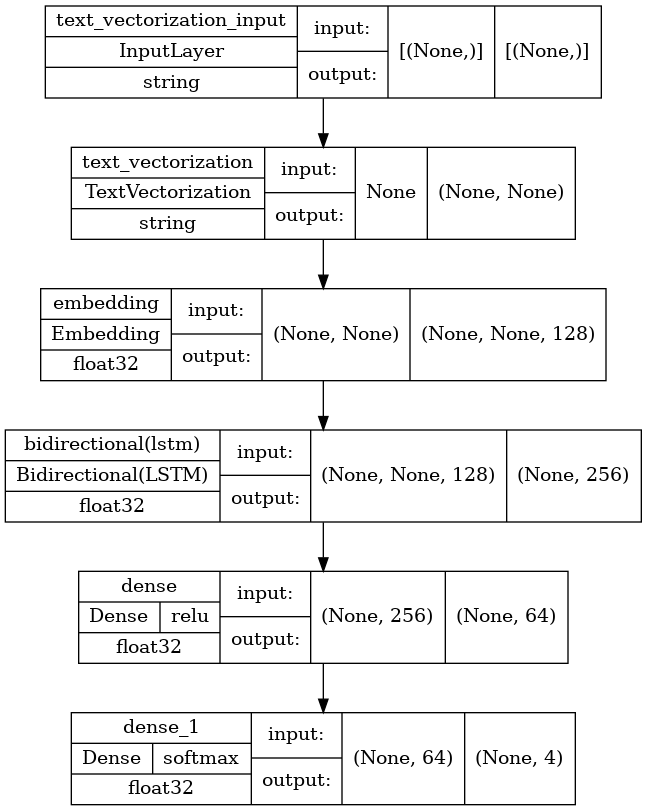

In [32]:
model_img_file = 'Bidirection_LSTM.png'
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

In [56]:
history = model.fit(train_data_f,epochs=25,validation_data=test_data_f,verbose=1,class_weight=weights)

# model.summary()

Epoch 1/25
925/925 [==============================] - 125s 117ms/step - loss: 1.1867 - accuracy: 0.5259 - val_loss: 0.9915 - val_accuracy: 0.6497
Epoch 2/25
925/925 [==============================] - 106s 113ms/step - loss: 0.8223 - accuracy: 0.7336 - val_loss: 0.8083 - val_accuracy: 0.7274
Epoch 3/25
925/925 [==============================] - 107s 115ms/step - loss: 0.6513 - accuracy: 0.8014 - val_loss: 0.7134 - val_accuracy: 0.7659
Epoch 4/25
925/925 [==============================] - 123s 132ms/step - loss: 0.5576 - accuracy: 0.8334 - val_loss: 0.6683 - val_accuracy: 0.7761
Epoch 5/25
925/925 [==============================] - 119s 127ms/step - loss: 0.4936 - accuracy: 0.8548 - val_loss: 0.6286 - val_accuracy: 0.7916
Epoch 6/25
925/925 [==============================] - 120s 129ms/step - loss: 0.4431 - accuracy: 0.8715 - val_loss: 0.6063 - val_accuracy: 0.7990
Epoch 7/25
925/925 [==============================] - 121s 129ms/step - loss: 0.4005 - accuracy: 0.8859 - val_loss: 0.5867 -

In [33]:
classes = [ 'Negative','Positive', 'Neutral', 'Irrelevant']

In [34]:
classes[model.predict(np.array(["I think the t 800s were ok disapointed that they do not explode when dying. I mean we are shooting a powercell that explodes the size of 30 to 60 pounds of C4."])).argmax()]

'Neutral'

In [35]:

classes[model.predict(np.array(["The best game I've played in the last few years is Red Dead Redeemption 2. One of the best games I've ever played."])).argmax()]

'Positive'